# Compute Trigger Efficiencies

### In this script, we use the output of a tag-N-probe script to select Z->mu mu events that generate a shower in the CMS Muon Detectors via muon brehmstahlung. We want to compute the efficiency of the HLT triggers that fire upon the production of a shower in the muon endcaps (CSCs). The "tag" muon with tighter ID enables us to select a high purity Z->mu mu sample, while the probe muon, with looser ID constraints, is matched to a cluster in the CSC (we do not require a tight ID on the probe muon to avoid biasing cluster selection). The size of a cluster is the main discriminator, but the HLT threshold varies with eta and NStation10. We compute the trigger efficiency as a function of these three variables.

In [107]:
import numpy as np
import pandas as pd
import uproot
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,"../")
import mplhep as hep
import pickle
import glob
import ROOT
import coffea
import awkward as ak
from coffea import hist, processor
from coffea.nanoevents.methods import candidate
from coffea.nanoevents.methods import vector


### Load Output Trees from TnP

In [108]:
eras = ["2022", "2023D"]

In [109]:
#paths to data
path_2022 = "/uscms/home/amalbert/nobackup/CMSSW_10_6_20/src/run3_llp_analyzer/fixedMerge_trigEff_2022_050724.root"
path_2023D = "/eos/uscms/store/user/amalbert/MDSTriggerEff/trigEff_output_2023/fixedMerge_trigEff_2023D_050724.root"

In [110]:
ak.behavior.update(candidate.behavior)

def getLZDF(f,nEvents=-1,version="new"): #lazy dataframe with events that have cluster matched to probe muon
    events_raw = uproot.open(f)['MuonSystem']
    df = coffea.processor.LazyDataFrame(events_raw,entrystop=nEvents)
    start,stop = df._branchargs['entry_start'],df._branchargs['entry_stop']
    events = uproot.lazy(df._tree)
    events = events[start:stop]
    return events

In [111]:
events_2022 = getLZDF(path_2022)
events_2023D = getLZDF(path_2023D)


In [112]:
all_data = {"2022": events_2022, "2023D": events_2023D}

In [113]:
events_2022.fields

['runNum',
 'MC_condition',
 'lumiSec',
 'evtNum',
 'mH',
 'mX',
 'ctau',
 'category',
 'npv',
 'npu',
 'weight',
 'lepOverallSF',
 'pileupWeight',
 'numProbeMuons',
 'Flag_HBHENoiseFilter',
 'Flag_BadPFMuonFilter',
 'Flag_HBHEIsoNoiseFilter',
 'Flag_CSCTightHaloFilter',
 'Flag_globalSuperTightHalo2016Filter',
 'Flag_goodVertices',
 'Flag_ecalBadCalibFilter',
 'Flag_BadChargedCandidateFilter',
 'Flag_eeBadScFilter',
 'Flag_all',
 'Flag2_HBHENoiseFilter',
 'Flag2_HBHEIsoNoiseFilter',
 'Flag2_BadPFMuonFilter',
 'Flag2_globalSuperTightHalo2016Filter',
 'Flag2_globalTightHalo2016Filter',
 'Flag2_BadChargedCandidateFilter',
 'Flag2_EcalDeadCellTriggerPrimitiveFilter',
 'Flag2_ecalBadCalibFilter',
 'Flag2_eeBadScFilter',
 'Flag2_all',
 'rho',
 'met',
 'metPhi',
 'gHiggsPt',
 'gHiggsE',
 'gHiggsEta',
 'gHiggsPhi',
 'nCscRings',
 'nDtRings',
 'nCscRechitClusters',
 'cscRechitCluster_match_gLLP',
 'cscRechitCluster_match_gLLP_minDeltaR',
 'cscRechitCluster_match_gLLP_index',
 'cscRechitCluster_

### Helper Functions

In [114]:
#helper functions for applying masks to large LZDF

def apply_event_mask(array, dataset_string, masks_list, remove_nones = False):
    '''
    Apply masks from event-by-event boolean branches.
    The masks must have the same length as the input array
    '''
    for mask in masks_list:
        array = ak.mask(array, all_data[dataset_string][mask])
    if remove_nones:
        return array[~ak.is_none(array)]
    return array

def apply_cluster_mask(array, dataset_string, masks_list, remove_nones = False):
    '''
    Apply masks from cluster-by-cluster boolean branches. The input ak.array should be pre-flattened.
    This can only be applied on fields of the LZDF whose flattened length equals the total number of clusters
    '''
    
    print(ak.count(array))
    for mask in masks_list:
        #if ak.count(array) != all_data[dataset_string][mask]:
         #   raise RuntimeError("input array and mask do not have the same length")
        array = ak.mask(array, ak.flatten(all_data[dataset_string][mask]))
    if remove_nones:
        return array[~ak.is_none(array)]
    return array

    

In [115]:
apply_cluster_mask(ak.flatten(events_2022.cscRechitClusterEta), "2022", ['cscRechitCluster_HLTCscCluster_Loose_Decision'])

304931


<Array [None, 1.43, None, ... None, None, None] type='304931 * ?float32'>

### First, use one cluster events to verify that our own calculation of the HLT Decision matches what is computed live

In [116]:
oneClusterEvents = {
    "2022": events_2022[events_2022["nCscRechitClusters"]==1],
    "2023D": events_2023D[events_2023D["nCscRechitClusters"]==1]
}

moreClusterEvents= {
    "2022": events_2022[events_2022["nCscRechitClusters"]>1],
    "2023D": events_2023D[events_2023D["nCscRechitClusters"]>1]
}

In [117]:
#validate manual computation of HLT Decision
HLT_validation_Loose = {}
for key,value in oneClusterEvents.items():
    HLT_validation_Loose[key] = {}
    HLT_validation_Loose[key]["fire_predict_yes"] = ak.count_nonzero(value["HLT_CscCluster_Loose"] & value["L1_SingleMuShower_Nominal"] & ak.flatten(value['cscRechitCluster_HLTCscCluster_Loose_Decision']))
    HLT_validation_Loose[key]["fire_predict_no"] = ak.count_nonzero(value["HLT_CscCluster_Loose"] & (~(ak.flatten(value['cscRechitCluster_HLTCscCluster_Loose_Decision'])) | ~value["L1_SingleMuShower_Nominal"]))
    HLT_validation_Loose[key]["no_fire_predict_yes"] = ak.count_nonzero(~(value["HLT_CscCluster_Loose"]) & (ak.flatten(value['cscRechitCluster_HLTCscCluster_Loose_Decision']) & value["L1_SingleMuShower_Nominal"]))
    HLT_validation_Loose[key]["no_fire_predict_no"] = ak.count_nonzero(~(value["HLT_CscCluster_Loose"]) & (~ak.flatten(value['cscRechitCluster_HLTCscCluster_Loose_Decision'])| ~value["L1_SingleMuShower_Nominal"]))
    
HLT_validation_Medium = {}
for key,value in oneClusterEvents.items():
    HLT_validation_Medium[key] = {}
    HLT_validation_Medium[key]["fire_predict_yes"] = ak.count_nonzero(value["HLT_CscCluster_Medium"] & value["L1_SingleMuShower_Nominal"] & ak.flatten(value['cscRechitCluster_HLTCscCluster_Medium_Decision']))
    HLT_validation_Medium[key]["fire_predict_no"] = ak.count_nonzero(value["HLT_CscCluster_Medium"] & (~(ak.flatten(value['cscRechitCluster_HLTCscCluster_Medium_Decision'])) | ~value["L1_SingleMuShower_Nominal"]))
    HLT_validation_Medium[key]["no_fire_predict_yes"] = ak.count_nonzero(~(value["HLT_CscCluster_Medium"]) & (ak.flatten(value['cscRechitCluster_HLTCscCluster_Medium_Decision']) & value["L1_SingleMuShower_Nominal"]))
    HLT_validation_Medium[key]["no_fire_predict_no"] = ak.count_nonzero(~(value["HLT_CscCluster_Medium"]) & (~ak.flatten(value['cscRechitCluster_HLTCscCluster_Medium_Decision'])| ~value["L1_SingleMuShower_Nominal"]))
                                                                        
HLT_validation_Tight = {}
for key,value in oneClusterEvents.items():
    HLT_validation_Tight[key] = {}
    HLT_validation_Tight[key]["fire_predict_yes"] = ak.count_nonzero(value["HLT_CscCluster_Tight"] & value["L1_SingleMuShower_Nominal"] & ak.flatten(value['cscRechitCluster_HLTCscCluster_Tight_Decision']))
    HLT_validation_Tight[key]["fire_predict_no"] = ak.count_nonzero(value["HLT_CscCluster_Tight"] & (~(ak.flatten(value['cscRechitCluster_HLTCscCluster_Tight_Decision'])) | ~value["L1_SingleMuShower_Nominal"]))
    HLT_validation_Tight[key]["no_fire_predict_yes"] = ak.count_nonzero(~(value["HLT_CscCluster_Tight"]) & (ak.flatten(value['cscRechitCluster_HLTCscCluster_Tight_Decision']) & value["L1_SingleMuShower_Nominal"]))
    HLT_validation_Tight[key]["no_fire_predict_no"] = ak.count_nonzero(~(value["HLT_CscCluster_Tight"]) & (~ak.flatten(value['cscRechitCluster_HLTCscCluster_Tight_Decision'])| ~value["L1_SingleMuShower_Nominal"]))

In [118]:
HLT_validation_Loose

{'2022': {'fire_predict_yes': 8484,
  'fire_predict_no': 615,
  'no_fire_predict_yes': 458,
  'no_fire_predict_no': 224574},
 '2023D': {'fire_predict_yes': 3970,
  'fire_predict_no': 225,
  'no_fire_predict_yes': 159,
  'no_fire_predict_no': 92765}}

In [119]:
HLT_validation_Medium

{'2022': {'fire_predict_yes': 5862,
  'fire_predict_no': 575,
  'no_fire_predict_yes': 444,
  'no_fire_predict_no': 227250},
 '2023D': {'fire_predict_yes': 2664,
  'fire_predict_no': 233,
  'no_fire_predict_yes': 155,
  'no_fire_predict_no': 94067}}

In [120]:
HLT_validation_Tight

{'2022': {'fire_predict_yes': 5369,
  'fire_predict_no': 570,
  'no_fire_predict_yes': 439,
  'no_fire_predict_no': 227753},
 '2023D': {'fire_predict_yes': 2425,
  'fire_predict_no': 230,
  'no_fire_predict_yes': 152,
  'no_fire_predict_no': 94312}}

### HLT Prediction comparison with L1+HLT combined decision
#### 1. L1 fire & HLT bit fire => (at least 1) HLT prediction should fire 
#### 2. L1 fire & HLT bit not fire => (all) HLT prediction should not fire
#### 3. L1 not fire & HLT bit fire =>(should have zero events here)
#### 4. L1 not fire & HLT not fire => HLT prediction should not fire

In [121]:
#test on one cluster events first

one_cluster_validation = {}

for key,value in oneClusterEvents.items():
    one_cluster_validation[key] = {}
    
    for thresh in ['Loose', 'Medium', 'Tight']:
        one_cluster_validation[key][thresh] = {}
        one_cluster_validation[key][thresh]["L1_fire_HLT_fire"] = {}
        one_cluster_validation[key][thresh]["L1_fire_HLT_not"] = {}
        one_cluster_validation[key][thresh]["L1_not_HLT_fire"] = {}
        one_cluster_validation[key][thresh]["L1_not_HLT_not"] = {}
        L1_fire_HLT_fire_pred_fire = ak.count_nonzero(value["HLT_CscCluster_"+thresh] & value["L1_SingleMuShower_Nominal"] & ak.flatten(value['cscRechitCluster_HLTCscCluster_'+thresh+'_Decision']))
        L1_fire_HLT_fire_pred_not = ak.count_nonzero(value["HLT_CscCluster_"+thresh] & value["L1_SingleMuShower_Nominal"] & ak.flatten(~value['cscRechitCluster_HLTCscCluster_'+thresh+'_Decision']))
        L1_fire_HLT_not_pred_fire = ak.count_nonzero(~value["HLT_CscCluster_"+thresh] & value["L1_SingleMuShower_Nominal"] & ak.flatten(value['cscRechitCluster_HLTCscCluster_'+thresh+'_Decision']))
        L1_fire_HLT_not_pred_not = ak.count_nonzero(~value["HLT_CscCluster_"+thresh] & value["L1_SingleMuShower_Nominal"] & ak.flatten(~value['cscRechitCluster_HLTCscCluster_'+thresh+'_Decision']))
        L1_not_HLT_fire_pred_fire = ak.count_nonzero(value["HLT_CscCluster_"+thresh] & ~value["L1_SingleMuShower_Nominal"] & ak.flatten(value['cscRechitCluster_HLTCscCluster_'+thresh+'_Decision']))
        L1_not_HLT_fire_pred_not = ak.count_nonzero(value["HLT_CscCluster_"+thresh] & ~value["L1_SingleMuShower_Nominal"] & ak.flatten(~value['cscRechitCluster_HLTCscCluster_'+thresh+'_Decision']))
        L1_not_HLT_not_pred_fire = ak.count_nonzero(~value["HLT_CscCluster_"+thresh] & ~value["L1_SingleMuShower_Nominal"] & ak.flatten(value['cscRechitCluster_HLTCscCluster_'+thresh+'_Decision']))
        L1_not_HLT_not_pred_not = ak.count_nonzero(~value["HLT_CscCluster_"+thresh] & ~value["L1_SingleMuShower_Nominal"] & ak.flatten(~value['cscRechitCluster_HLTCscCluster_'+thresh+'_Decision']))
        one_cluster_validation[key][thresh]["L1_fire_HLT_fire"] = (L1_fire_HLT_fire_pred_fire, L1_fire_HLT_fire_pred_not)
        one_cluster_validation[key][thresh]["L1_fire_HLT_not"] = (L1_fire_HLT_not_pred_fire, L1_fire_HLT_not_pred_not)
        one_cluster_validation[key][thresh]["L1_not_HLT_fire"] = (L1_not_HLT_fire_pred_fire, L1_not_HLT_fire_pred_not)
        one_cluster_validation[key][thresh]["L1_not_HLT_not"] = (L1_not_HLT_not_pred_fire, L1_not_HLT_not_pred_not)


In [179]:
print(one_cluster_validation['2022']['Loose'])

{'L1_fire_HLT_fire': (8484, 564), 'L1_fire_HLT_not': (458, 92780), 'L1_not_HLT_fire': (49, 2), 'L1_not_HLT_not': (3276, 128518)}


### Plot Z-Peak (or other event-by-event hists)

/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:43: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(


(0.0, 200.0)

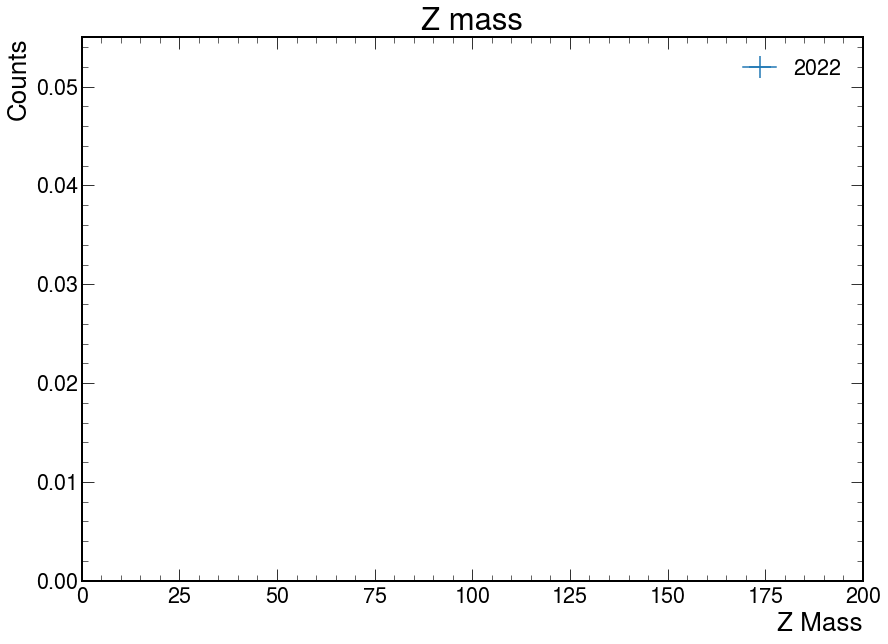

In [123]:
plt.style.use(hep.style.CMS) 
plt.figure(figsize=(14,10))
rechits_axis = hist.Cat("sample", "2022")
ZMass_hist = hist.Hist("Counts", rechits_axis, hist.Bin("ZMass", "Z Mass", 100, 25, 150))
ZMass_hist.fill(sample = '2022', ZMass = events_2022.ZMass)
hist.plot1d(ZMass_hist, density=False)
plt.legend()
plt.title("Z mass")
plt.xlim(0,200)

### Plot Trigger Efficiencies and Other Cluser-by-Cluster Variables

In [124]:
#compute mask for whether a cluster has been matched to a probe muon
matched_clusters_mask = {}
for era in eras:
    one_cluster_mask = np.logical_and(ak.flatten(oneClusterEvents[era].cscRechitCluster_matchToProbeMuon), ak.flatten(oneClusterEvents[era].cscRechitCluster_PassTimeVeto)) 
    one_cluster_mask = np.logical_and(one_cluster_mask, (ak.flatten(oneClusterEvents[era].cscRechitClusterNRechitChamberPlus11)+ak.flatten(oneClusterEvents[era].cscRechitClusterNRechitChamberPlus12)+ak.flatten(oneClusterEvents[era].cscRechitClusterNRechitChamberMinus11)+ak.flatten(oneClusterEvents[era].cscRechitClusterNRechitChamberMinus12)==0))
    many_cluster_mask = np.logical_and(ak.flatten(moreClusterEvents[era].cscRechitCluster_matchToProbeMuon), ak.flatten(moreClusterEvents[era].cscRechitCluster_PassTimeVeto))
    many_cluster_mask = np.logical_and(many_cluster_mask, (ak.flatten(moreClusterEvents[era].cscRechitClusterNRechitChamberPlus11)+ak.flatten(moreClusterEvents[era].cscRechitClusterNRechitChamberPlus12)+ak.flatten(moreClusterEvents[era].cscRechitClusterNRechitChamberMinus11)+ak.flatten(moreClusterEvents[era].cscRechitClusterNRechitChamberMinus12)==0))
    matched_clusters_mask[era] = ak.concatenate([one_cluster_mask, many_cluster_mask])

In [125]:
# load HLT Decisions on a cluster-by-cluster basis
# use HLT decision for one cluster events, computed "prediction" for events with more than one cluster
# apply matched cluster mask

HLT_Loose_Decision = {}
for era in eras:
    HLT_Loose_Decision[era] = ak.mask(ak.concatenate([oneClusterEvents[era].HLT_CscCluster_Loose, ak.flatten(moreClusterEvents[era].cscRechitCluster_HLTCscCluster_Loose_Decision)]), matched_clusters_mask[era])
    HLT_Loose_Decision[era] = HLT_Loose_Decision[era][~ak.is_none(HLT_Loose_Decision[era])]

HLT_Medium_Decision = {}
for era in eras:
    HLT_Medium_Decision[era] = ak.mask(ak.concatenate([oneClusterEvents[era].HLT_CscCluster_Medium, ak.flatten(moreClusterEvents[era].cscRechitCluster_HLTCscCluster_Medium_Decision)]), matched_clusters_mask[era])
    HLT_Medium_Decision[era] = HLT_Medium_Decision[era][~ak.is_none(HLT_Medium_Decision[era])]

HLT_Tight_Decision = {}
for era in eras:
    HLT_Tight_Decision[era] = ak.mask(ak.concatenate([oneClusterEvents[era].HLT_CscCluster_Tight, ak.flatten(moreClusterEvents[era].cscRechitCluster_HLTCscCluster_Tight_Decision)]), matched_clusters_mask[era])
    HLT_Tight_Decision[era] = HLT_Tight_Decision[era][~ak.is_none(HLT_Tight_Decision[era])]

In [126]:
#load rechits, eta, and NStation10
matched_clusters_nhits = {}
for era in eras:
    matched_clusters_nhits[era] = ak.mask(ak.concatenate([ak.flatten(oneClusterEvents[era].cscRechitClusterSize), ak.flatten(moreClusterEvents[era].cscRechitClusterSize)]), matched_clusters_mask[era])
    matched_clusters_nhits[era] = matched_clusters_nhits[era][~ak.is_none(matched_clusters_nhits[era])]
    
matched_clusters_eta = {}
for era in eras:
    matched_clusters_eta[era] = ak.mask(ak.concatenate([ak.flatten(oneClusterEvents[era].cscRechitClusterEta), ak.flatten(moreClusterEvents[era].cscRechitClusterEta)]), matched_clusters_mask[era])
    matched_clusters_eta[era] = matched_clusters_eta[era][~ak.is_none(matched_clusters_eta[era])]
    
matched_clusters_NStation10 = {}
for era in eras:
    matched_clusters_NStation10[era] = ak.mask(ak.concatenate([ak.flatten(oneClusterEvents[era].cscRechitClusterNStation10), ak.flatten(moreClusterEvents[era].cscRechitClusterNStation10)]), matched_clusters_mask[era])
    matched_clusters_NStation10[era] = matched_clusters_NStation10[era][~ak.is_none(matched_clusters_NStation10[era])]

### Efficiencies binned by both Eta and NStation10 (one cluster events only)
#### Bins correspond to categories for which loose, medium, and tight thresholds are set

In [127]:
print(ak.count_nonzero(oneClusterEvents['2022'].nCscRechitClusters))
ak.count_nonzero(moreClusterEvents['2022'].nCscRechitClusters)

234131


34016

In [181]:
#first, only consider one-cluster data
one_cluster_mask = {}
for era in eras:
    one_cluster_mask[era] = np.logical_and(ak.flatten(oneClusterEvents[era].cscRechitCluster_matchToProbeMuon), ak.flatten(oneClusterEvents[era].cscRechitCluster_PassTimeVeto))
    one_cluster_mask[era] = np.logical_and(one_cluster_mask[era], (ak.flatten(oneClusterEvents[era].cscRechitClusterNRechitChamberPlus11)+ak.flatten(oneClusterEvents[era].cscRechitClusterNRechitChamberPlus12)+ak.flatten(oneClusterEvents[era].cscRechitClusterNRechitChamberMinus11)+ak.flatten(oneClusterEvents[era].cscRechitClusterNRechitChamberMinus12)==0))
    
HLT_Loose_Decision_oneCluster = {}
for era in eras:
    HLT_Loose_Decision_oneCluster[era] = ak.mask(oneClusterEvents[era].HLT_CscCluster_Loose, one_cluster_mask[era])
    HLT_Loose_Decision_oneCluster[era] = HLT_Loose_Decision_oneCluster[era][~ak.is_none(HLT_Loose_Decision_oneCluster[era])]

HLT_Medium_Decision_oneCluster = {}
for era in eras:
    HLT_Medium_Decision_oneCluster[era] = ak.mask(oneClusterEvents[era].HLT_CscCluster_Medium,one_cluster_mask[era])
    HLT_Medium_Decision_oneCluster[era] = HLT_Medium_Decision_oneCluster[era][~ak.is_none(HLT_Medium_Decision_oneCluster[era])]

HLT_Tight_Decision_oneCluster = {}
for era in eras:
    HLT_Tight_Decision_oneCluster[era] = ak.mask(oneClusterEvents[era].HLT_CscCluster_Tight, one_cluster_mask[era])
    HLT_Tight_Decision_oneCluster[era] = HLT_Tight_Decision_oneCluster[era][~ak.is_none(HLT_Tight_Decision_oneCluster[era])]
    
#load rechits, eta, and NStation10
one_cluster_nhits = {}
for era in eras:
    one_cluster_nhits[era] = ak.mask(ak.flatten(oneClusterEvents[era].cscRechitClusterSize), one_cluster_mask[era])
    one_cluster_nhits[era] = one_cluster_nhits[era][~ak.is_none(one_cluster_nhits[era])]
    
one_cluster_eta = {}
for era in eras:
    one_cluster_eta[era] = np.abs(ak.mask(ak.flatten(oneClusterEvents[era].cscRechitClusterEta), one_cluster_mask[era]))
    one_cluster_eta[era] = one_cluster_eta[era][~ak.is_none(one_cluster_eta[era])]
    
one_cluster_NStation10 = {}
for era in eras:
    one_cluster_NStation10[era] = ak.mask(ak.flatten(oneClusterEvents[era].cscRechitClusterNStation10), one_cluster_mask[era])
    one_cluster_NStation10[era] = one_cluster_NStation10[era][~ak.is_none(one_cluster_NStation10[era])]

In [182]:
sample = '2023D'
era = sample

In [183]:
#define bins based on eta/NStation10 regions that set trigger thresholds
bins_eta_big = hist.Bin("eta", "eta", np.linspace(0,1.9,1))
bins_NStation10_big= hist.Bin("NStation10", "NStation10", np.linspace(0,1,1))
eta_NStation10_axis = hist.Cat("sample", sample)

In [184]:
#separate data into the correct one of the four eta/NStation10 bins

one_cluster_lowEta_lowNStation10, one_cluster_lowEta_highNStation10, one_cluster_highEta_lowNStation10, one_cluster_highEta_highNStation10 = {},{},{},{}
#era = '2022'
#oneClusterEvents[era] = ak.mask(oneClusterEvents[era], one_cluster_mask[era])

one_cluster_lowEta_lowNStation10['Denominator'] = ak.mask(oneClusterEvents[era],np.logical_and(np.logical_and(ak.flatten(oneClusterEvents[era].cscRechitClusterEta<1.9), ak.flatten(oneClusterEvents[era].cscRechitClusterNStation10<=1)), one_cluster_mask[era]))
one_cluster_lowEta_lowNStation10['Denominator'] = one_cluster_lowEta_lowNStation10["Denominator"][~ak.is_none(one_cluster_lowEta_lowNStation10["Denominator"])]
one_cluster_lowEta_highNStation10['Denominator'] = ak.mask(oneClusterEvents[era],np.logical_and(np.logical_and(ak.flatten(oneClusterEvents[era].cscRechitClusterEta<1.9), ak.flatten(oneClusterEvents[era].cscRechitClusterNStation10>1)), one_cluster_mask[era]))
one_cluster_lowEta_highNStation10['Denominator'] = one_cluster_lowEta_highNStation10["Denominator"][~ak.is_none(one_cluster_lowEta_highNStation10["Denominator"])]
one_cluster_highEta_lowNStation10['Denominator'] = ak.mask(oneClusterEvents[era],np.logical_and(np.logical_and(ak.flatten(oneClusterEvents[era].cscRechitClusterEta>=1.9), ak.flatten(oneClusterEvents[era].cscRechitClusterNStation10<=1)),one_cluster_mask[era]))
one_cluster_highEta_lowNStation10['Denominator'] = one_cluster_highEta_lowNStation10["Denominator"][~ak.is_none(one_cluster_highEta_lowNStation10["Denominator"])]
one_cluster_highEta_highNStation10['Denominator'] = ak.mask(oneClusterEvents[era],np.logical_and(np.logical_and(ak.flatten(oneClusterEvents[era].cscRechitClusterEta>=1.9), ak.flatten(oneClusterEvents[era].cscRechitClusterNStation10>1)),one_cluster_mask[era]))
one_cluster_highEta_highNStation10['Denominator'] = one_cluster_highEta_highNStation10["Denominator"][~ak.is_none(one_cluster_highEta_highNStation10["Denominator"])]

one_cluster_lowEta_lowNStation10['Numerator_Loose'] = ak.mask(one_cluster_lowEta_lowNStation10['Denominator'], one_cluster_lowEta_lowNStation10['Denominator'].HLT_CscCluster_Loose)
one_cluster_lowEta_lowNStation10['Numerator_Loose'] = one_cluster_lowEta_lowNStation10['Numerator_Loose'][~ak.is_none(one_cluster_lowEta_lowNStation10["Numerator_Loose"])]
one_cluster_lowEta_lowNStation10['Numerator_Medium'] = ak.mask(one_cluster_lowEta_lowNStation10['Denominator'], one_cluster_lowEta_lowNStation10['Denominator'].HLT_CscCluster_Medium)
one_cluster_lowEta_lowNStation10['Numerator_Medium'] = one_cluster_lowEta_lowNStation10['Numerator_Medium'][~ak.is_none(one_cluster_lowEta_lowNStation10["Numerator_Medium"])]
one_cluster_lowEta_lowNStation10['Numerator_Tight'] = ak.mask(one_cluster_lowEta_lowNStation10['Denominator'], one_cluster_lowEta_lowNStation10['Denominator'].HLT_CscCluster_Tight)
one_cluster_lowEta_lowNStation10['Numerator_Tight'] = one_cluster_lowEta_lowNStation10['Numerator_Tight'][~ak.is_none(one_cluster_lowEta_lowNStation10["Numerator_Tight"])]

one_cluster_lowEta_highNStation10['Numerator_Loose'] = ak.mask(one_cluster_lowEta_highNStation10['Denominator'], one_cluster_lowEta_highNStation10['Denominator'].HLT_CscCluster_Loose)
one_cluster_lowEta_highNStation10['Numerator_Loose'] = one_cluster_lowEta_highNStation10['Numerator_Loose'][~ak.is_none(one_cluster_lowEta_highNStation10["Numerator_Loose"])]
one_cluster_lowEta_highNStation10['Numerator_Medium'] = ak.mask(one_cluster_lowEta_highNStation10['Denominator'], one_cluster_lowEta_highNStation10['Denominator'].HLT_CscCluster_Medium)
one_cluster_lowEta_highNStation10['Numerator_Medium'] = one_cluster_lowEta_highNStation10['Numerator_Medium'][~ak.is_none(one_cluster_lowEta_highNStation10["Numerator_Medium"])]
one_cluster_lowEta_highNStation10['Numerator_Tight'] = ak.mask(one_cluster_lowEta_highNStation10['Denominator'], one_cluster_lowEta_highNStation10['Denominator'].HLT_CscCluster_Tight)
one_cluster_lowEta_highNStation10['Numerator_Tight'] = one_cluster_lowEta_highNStation10['Numerator_Tight'][~ak.is_none(one_cluster_lowEta_highNStation10["Numerator_Tight"])]

one_cluster_highEta_lowNStation10['Numerator_Loose'] = ak.mask(one_cluster_highEta_lowNStation10['Denominator'], one_cluster_highEta_lowNStation10['Denominator'].HLT_CscCluster_Loose)
one_cluster_highEta_lowNStation10['Numerator_Loose'] = one_cluster_highEta_lowNStation10['Numerator_Loose'][~ak.is_none(one_cluster_highEta_lowNStation10["Numerator_Loose"])]
one_cluster_highEta_lowNStation10['Numerator_Medium'] = ak.mask(one_cluster_highEta_lowNStation10['Denominator'], one_cluster_highEta_lowNStation10['Denominator'].HLT_CscCluster_Medium)
one_cluster_highEta_lowNStation10['Numerator_Medium'] = one_cluster_highEta_lowNStation10['Numerator_Medium'][~ak.is_none(one_cluster_highEta_lowNStation10["Numerator_Medium"])]
one_cluster_highEta_lowNStation10['Numerator_Tight'] = ak.mask(one_cluster_highEta_lowNStation10['Denominator'], one_cluster_highEta_lowNStation10['Denominator'].HLT_CscCluster_Tight)
one_cluster_highEta_lowNStation10['Numerator_Tight'] = one_cluster_highEta_lowNStation10['Numerator_Tight'][~ak.is_none(one_cluster_highEta_lowNStation10["Numerator_Tight"])]

one_cluster_highEta_highNStation10['Numerator_Loose'] = ak.mask(one_cluster_highEta_highNStation10['Denominator'], one_cluster_highEta_highNStation10['Denominator'].HLT_CscCluster_Loose)
one_cluster_highEta_highNStation10['Numerator_Loose'] = one_cluster_highEta_highNStation10['Numerator_Loose'][~ak.is_none(one_cluster_highEta_highNStation10["Numerator_Loose"])]
one_cluster_highEta_highNStation10['Numerator_Medium'] = ak.mask(one_cluster_highEta_highNStation10['Denominator'], one_cluster_highEta_highNStation10['Denominator'].HLT_CscCluster_Medium)
one_cluster_highEta_highNStation10['Numerator_Medium'] = one_cluster_highEta_highNStation10['Numerator_Medium'][~ak.is_none(one_cluster_highEta_highNStation10["Numerator_Medium"])]
one_cluster_highEta_highNStation10['Numerator_Tight'] = ak.mask(one_cluster_highEta_highNStation10['Denominator'], one_cluster_highEta_highNStation10['Denominator'].HLT_CscCluster_Tight)
one_cluster_highEta_highNStation10['Numerator_Tight'] = one_cluster_highEta_highNStation10['Numerator_Tight'][~ak.is_none(one_cluster_highEta_highNStation10["Numerator_Tight"])]


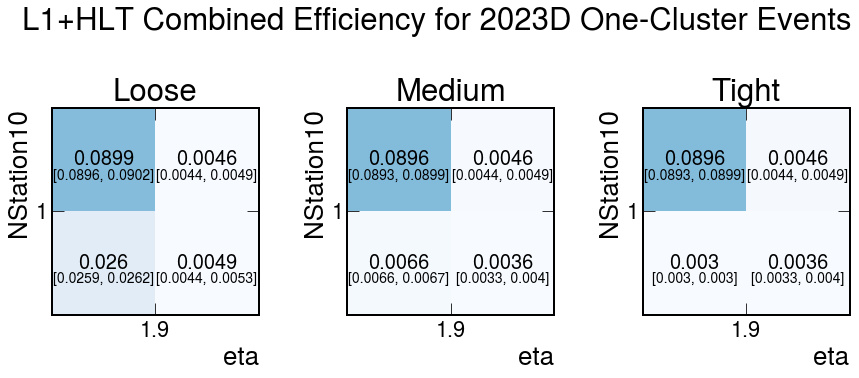

In [185]:
from statsmodels.stats.proportion import proportion_confint
num_rows = 1
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))
fig.suptitle("L1+HLT Combined Efficiency for " + sample + " One-Cluster Events")
thresholds = ["Loose", "Medium", "Tight"]


matrix_loose = np.array([
        [round(ak.count(one_cluster_lowEta_highNStation10['Numerator_Loose'])/ak.count(one_cluster_lowEta_highNStation10['Denominator']),4), round(ak.count(one_cluster_highEta_highNStation10['Numerator_Loose'])/ak.count(one_cluster_highEta_highNStation10['Denominator']),4)],
        [round(ak.count(one_cluster_lowEta_lowNStation10['Numerator_Loose'])/ak.count(one_cluster_lowEta_lowNStation10['Denominator']),4), round(ak.count(one_cluster_highEta_lowNStation10['Numerator_Loose'])/ak.count(one_cluster_highEta_lowNStation10['Denominator']),4)]
    ])
matrix_loose_errors = np.array([
        [proportion_confint(ak.count(one_cluster_lowEta_highNStation10['Numerator_Loose']),ak.count(one_cluster_lowEta_highNStation10['Denominator']), alpha=0.05, method='beta'), proportion_confint(ak.count(one_cluster_highEta_highNStation10['Numerator_Loose']),ak.count(one_cluster_highEta_highNStation10['Denominator']), alpha=0.05, method='beta')],
        [proportion_confint(ak.count(one_cluster_lowEta_lowNStation10['Numerator_Loose']),ak.count(one_cluster_lowEta_lowNStation10['Denominator']), alpha=0.05, method='beta'), proportion_confint(ak.count(one_cluster_highEta_lowNStation10['Numerator_Loose']),ak.count(one_cluster_highEta_lowNStation10['Denominator']), alpha=0.05, method='beta')]
    ])

matrix_medium = np.array([
        [round(ak.count(one_cluster_lowEta_highNStation10['Numerator_Medium'])/ak.count(one_cluster_lowEta_highNStation10['Denominator']),4), round(ak.count(one_cluster_highEta_highNStation10['Numerator_Medium'])/ak.count(one_cluster_highEta_highNStation10['Denominator']),4)],
        [round(ak.count(one_cluster_lowEta_lowNStation10['Numerator_Medium'])/ak.count(one_cluster_lowEta_lowNStation10['Denominator']),4), round(ak.count(one_cluster_highEta_lowNStation10['Numerator_Medium'])/ak.count(one_cluster_highEta_lowNStation10['Denominator']),4)]
    ])
matrix_medium_errors = np.array([
        [proportion_confint(ak.count(one_cluster_lowEta_highNStation10['Numerator_Medium']),ak.count(one_cluster_lowEta_highNStation10['Denominator']), alpha=0.05, method='beta'), proportion_confint(ak.count(one_cluster_highEta_highNStation10['Numerator_Medium']),ak.count(one_cluster_highEta_highNStation10['Denominator']), alpha=0.05, method='beta')],
        [proportion_confint(ak.count(one_cluster_lowEta_lowNStation10['Numerator_Medium']),ak.count(one_cluster_lowEta_lowNStation10['Denominator']), alpha=0.05, method='beta'), proportion_confint(ak.count(one_cluster_highEta_lowNStation10['Numerator_Medium']),ak.count(one_cluster_highEta_lowNStation10['Denominator']), alpha=0.05, method='beta')]
    ])

matrix_tight = np.array([
        [round(ak.count(one_cluster_lowEta_highNStation10['Numerator_Tight'])/ak.count(one_cluster_lowEta_highNStation10['Denominator']),4), round(ak.count(one_cluster_highEta_highNStation10['Numerator_Tight'])/ak.count(one_cluster_highEta_highNStation10['Denominator']),4)],
        [round(ak.count(one_cluster_lowEta_lowNStation10['Numerator_Tight'])/ak.count(one_cluster_lowEta_lowNStation10['Denominator']),4), round(ak.count(one_cluster_highEta_lowNStation10['Numerator_Tight'])/ak.count(one_cluster_highEta_lowNStation10['Denominator']),4)]
    ])
matrix_tight_errors = np.array([
        [proportion_confint(ak.count(one_cluster_lowEta_highNStation10['Numerator_Tight']),ak.count(one_cluster_lowEta_highNStation10['Denominator']), alpha=0.05, method='beta'), proportion_confint(ak.count(one_cluster_highEta_highNStation10['Numerator_Tight']),ak.count(one_cluster_highEta_highNStation10['Denominator']), alpha=0.05, method='beta')],
        [proportion_confint(ak.count(one_cluster_lowEta_lowNStation10['Numerator_Tight']),ak.count(one_cluster_lowEta_lowNStation10['Denominator']), alpha=0.05, method='beta'), proportion_confint(ak.count(one_cluster_highEta_lowNStation10['Numerator_Tight']),ak.count(one_cluster_highEta_lowNStation10['Denominator']), alpha=0.05, method='beta')]
    ])
matrices_efficiencies = {"Loose": matrix_loose, "Medium": matrix_medium, "Tight": matrix_tight}
matrices_intervals = {"Loose": matrix_loose_errors, "Medium": matrix_medium_errors, "Tight": matrix_tight_errors}


for idx, threshold_name in enumerate(thresholds):
    row = idx // num_cols
    col = idx % num_cols
    
    axes[col].imshow(matrices_efficiencies[threshold_name], cmap=plt.cm.Blues, vmax=0.2)
    #axes.set_title(subkey)
    axes[col].set_title(threshold_name)
    axes[col].set_xlabel('eta')
    axes[col].set_ylabel('NStation10')
    axes[col].set_xticks([0.5])
    axes[col].set_yticks([0.5])

    # Set tick labels
    axes[col].set_xticklabels(['1.9'])
    axes[col].set_yticklabels(['1'])

    for i in range(2):
        for j in range(2):
            axes[col].text(j, i, str(matrices_efficiencies[threshold_name][i, j]), ha='center', va='center', color='black', fontsize=20)
            axes[col].text(j, i, '\n\n[' + str(round(matrices_intervals[threshold_name][i,j][0],4)) + ", " + str(round(matrices_intervals[threshold_name][i,j][1],4)) + ']', ha='center', va='center', color='black', fontsize=14)
plt.subplots_adjust(top=0.7)
plt.show()

### Now, make the same cluster size vs efficiency plots on a bin by bin basis

In [186]:
bins_rechits_lowEta_lowNStation10 = hist.Bin("cluster_size", "Cluster Size", np.concatenate([np.arange(0, 200, 20), np.arange(200, 1000, 100)]))
bins_rechits_lowEta_highNStation10 = hist.Bin("cluster_size", "Cluster Size", np.concatenate([np.arange(0, 100, 20), np.arange(100, 1000, 100)]))
echits_axis = hist.Cat("sample", sample)

In [187]:
def make_plots_hits_efficiency(data, title, bins):
    plt.style.use(hep.style.CMS) 
    num_rows = 1
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(8 * num_cols, 8 * num_rows))
    fig.suptitle(sample + " " + title)
    rechits_hist = hist.Hist("Counts", rechits_axis, bins)
    arr_to_plot = ak.flatten(data["Denominator"].cscRechitClusterSize)
    rechits_hist.fill(sample = f"2022 - {ak.count(arr_to_plot)} entries", cluster_size=arr_to_plot)
    hist.plot1d(rechits_hist, density=False, ax = axes[0])
    axes[0].legend()
    axes[0].set_title("Z -> mu mu + MDS Events", fontsize=24)
    axes[0].set_xlim(0,400)
    axes[0].set_xlabel("Cluster Size", fontsize=20)
    axes[0].set_ylabel("Counts", fontsize=20)
    

    rechits_hist_HLTLoose = hist.Hist("Counts", rechits_axis, bins)
    arr_to_plot = ak.flatten(data["Numerator_Loose"].cscRechitClusterSize)
    rechits_hist_HLTLoose.fill(sample = f"Loose - {ak.count(arr_to_plot)} entries", cluster_size=arr_to_plot)
    hist.plot1d(rechits_hist_HLTLoose, density=False, ax=axes[1], clear=False)

    '''
    rechits_hist_HLTMedium = hist.Hist("Counts", rechits_axis, bins_rechits)
    arr_to_plot = ak.flatten(data["Numerator_Medium"].cscRechitClusterSize)
    rechits_hist_HLTMedium.fill(sample = f"Medium - {ak.count(arr_to_plot)} entries", cluster_size=arr_to_plot)
    hist.plot1d(rechits_hist_HLTMedium, density=False, ax=axes[1],clear=False)

    rechits_hist_HLTTight = hist.Hist("Counts", rechits_axis, bins_rechits)
    arr_to_plot = ak.flatten(data["Numerator_Tight"].cscRechitClusterSize)
    rechits_hist_HLTTight.fill(sample = f"Tight - {ak.count(arr_to_plot)} entries", cluster_size=arr_to_plot)
    hist.plot1d(rechits_hist_HLTTight, density=False, ax=axes[1], clear=False)
    '''
    
    axes[1].set_title("Z -> mu mu + MDS + Fire HLT Events", fontsize=24)
    axes[1].legend()
    axes[1].set_xlabel("Cluster Size", fontsize=20)
    axes[1].set_ylabel("Counts", fontsize=20)
    import matplotlib
    
    hist.plotratio(
                ax=axes[2],
                num  =rechits_hist_HLTLoose.project(bins),
                denom=rechits_hist.project(bins),
                error_opts={'marker': '.'},
                unc='clopper-pearson',
                label= "Loose",
                clear=False
            )
    '''
    hist.plotratio(
                ax=axes[2],
                num  =rechits_hist_HLTMedium.project(bins_rechits),
                denom=rechits_hist.project(bins_rechits),
                error_opts={'marker': '.'},
                unc='clopper-pearson',
                label= "Medium",
                clear=False
            )

    hist.plotratio(
                ax=axes[2],
                num  =rechits_hist_HLTTight.project(bins_rechits),
                denom=rechits_hist.project(bins_rechits),
                error_opts={'marker': '.'},
                unc='clopper-pearson',
                label= "Tight",
                clear=False
            )
    '''
    axes[2].legend()
    axes[2].set_title("Efficiency vs Cluster Size", fontsize=24)
    axes[2].set_xlabel("Cluster Size", fontsize=20)
    axes[2].set_ylabel("L1+HLT Efficiency", fontsize=20)
    plt.subplots_adjust(top=0.85)
    plt.show()
    
    

/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


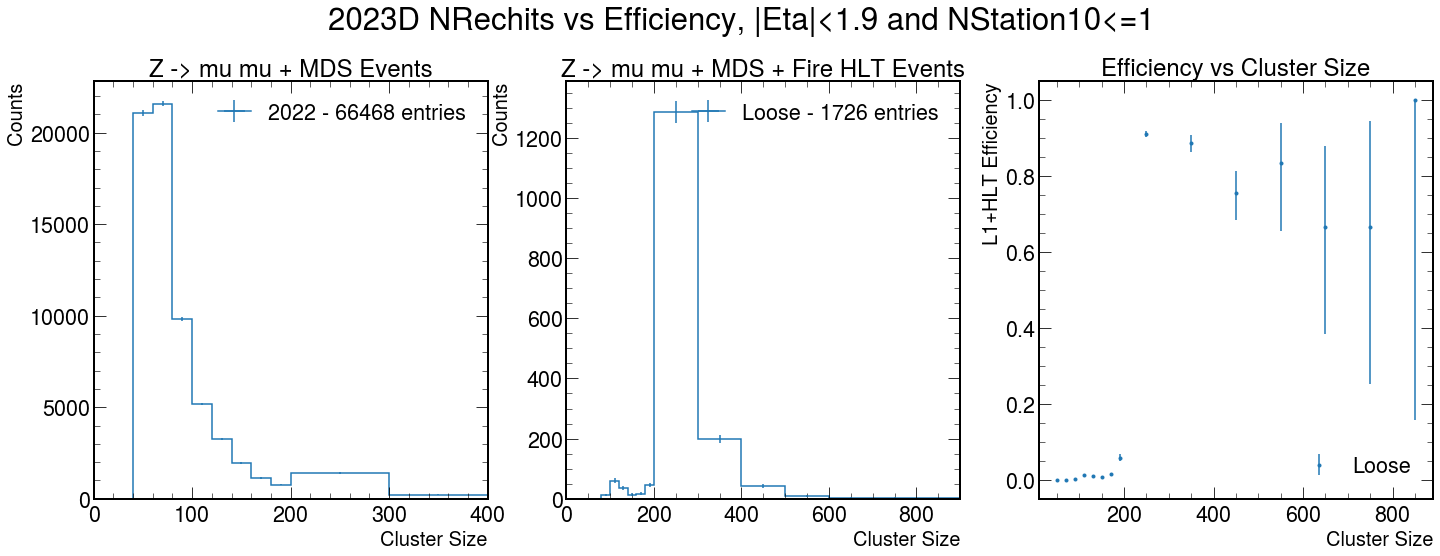

In [188]:
make_plots_hits_efficiency(data=one_cluster_lowEta_lowNStation10, title="NRechits vs Efficiency, |Eta|<1.9 and NStation10<=1",
                          bins=bins_rechits_lowEta_lowNStation10)

/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


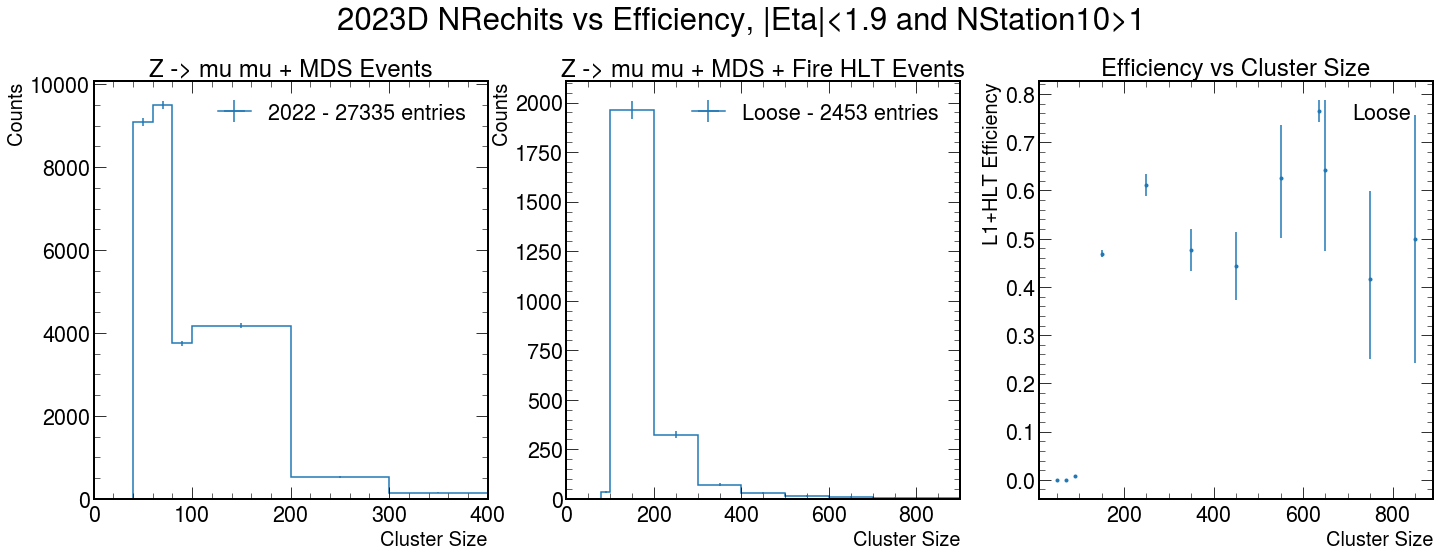

In [189]:
make_plots_hits_efficiency(data=one_cluster_lowEta_highNStation10, title="NRechits vs Efficiency, |Eta|<1.9 and NStation10>1",
                          bins=bins_rechits_lowEta_highNStation10)

/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


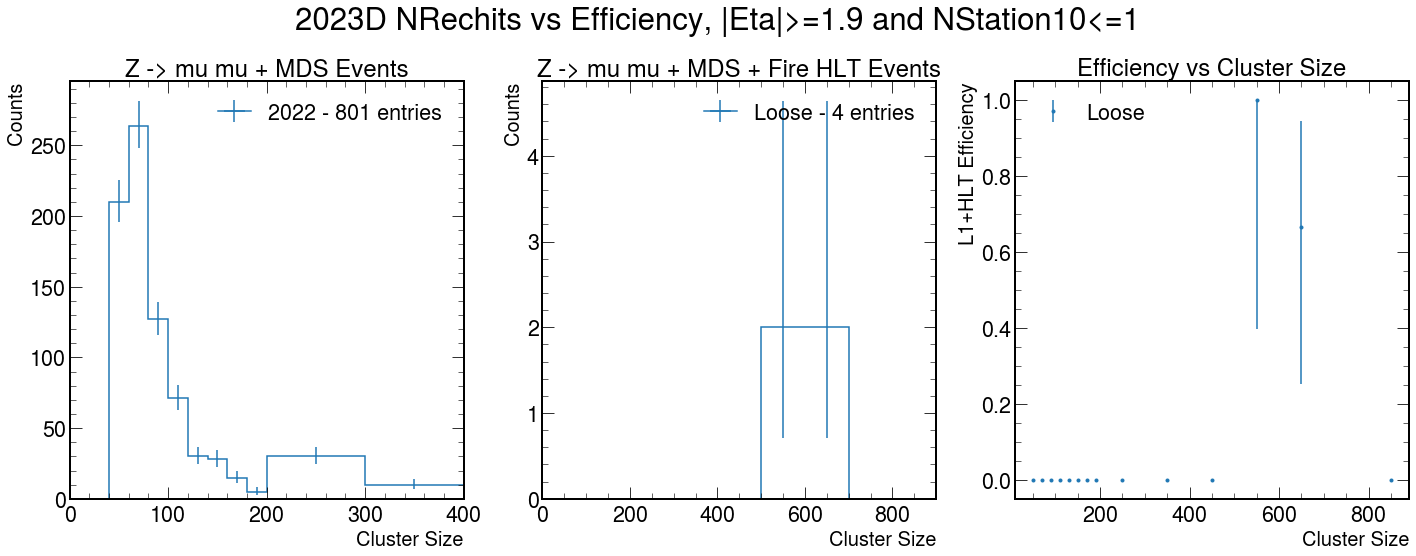

In [190]:
make_plots_hits_efficiency(data=one_cluster_highEta_lowNStation10, title="NRechits vs Efficiency, |Eta|>=1.9 and NStation10<=1",
                          bins=bins_rechits_lowEta_lowNStation10)

/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


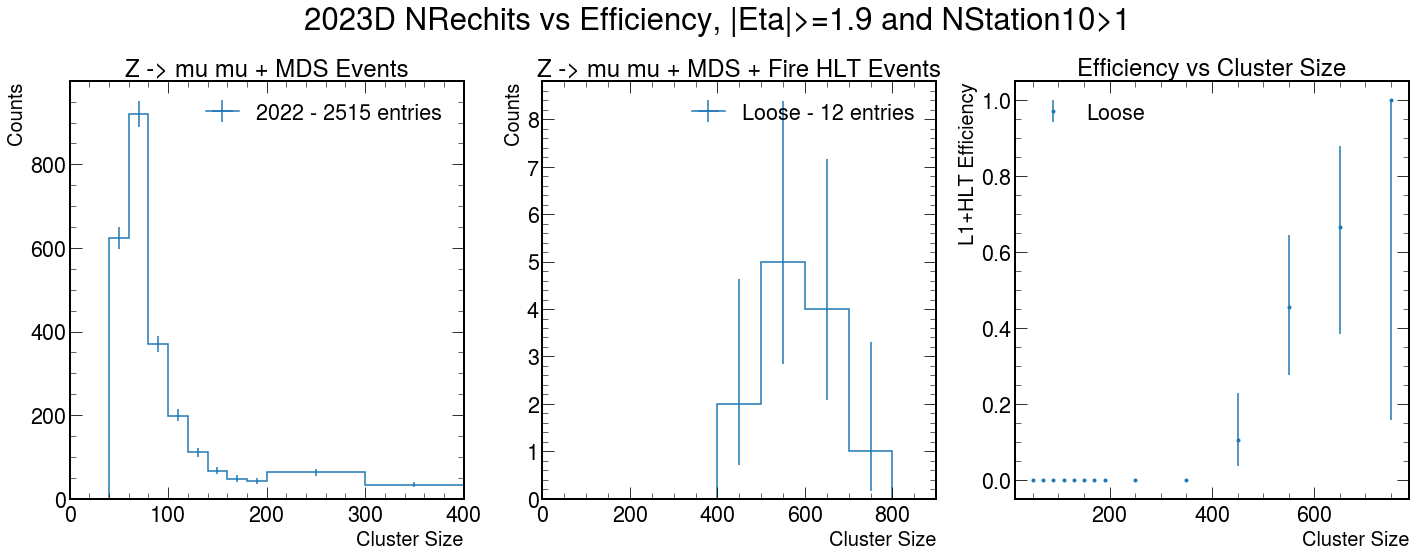

In [191]:
make_plots_hits_efficiency(data=one_cluster_highEta_highNStation10, title="NRechits vs Efficiency, |Eta|>=1.9 and NStation10>1",
                          bins=bins_rechits_lowEta_lowNStation10)

### L1 Efficiency by Chamber

In [192]:
chamber_locations = {
    "ME11": {"MinR": 100, "MaxR": 275, "minZ": 580, "maxZ": 632, "HLT_thresh": 500},
    "ME12": {"MinR": 275, "MaxR": 465, "minZ": 668, "maxZ": 725, "HLT_thresh": 200},
    "ME13": {"MinR": 505, "MaxR": 700, "minZ": 668, "maxZ": 724, "HLT_thresh": 200},
    "ME21": {"MinR": 139, "MaxR": 345, "minZ": 789, "maxZ": 850, "HLT_thresh": 500},
    "ME22": {"MinR": 357, "MaxR": 700, "minZ": 791, "maxZ": 850, "HLT_thresh": 200},
    "ME31": {"MinR": 160, "MaxR": 345, "minZ": 915, "maxZ": 970, "HLT_thresh": 500},
    "ME32": {"MinR": 357, "MaxR": 700, "minZ": 911, "maxZ": 970, "HLT_thresh": 200},
    "ME41": {"MinR": 178, "MaxR": 345, "minZ": 1002, "maxZ": 1063, "HLT_thresh": 500},
    "ME42": {"MinR": 357, "MaxR": 700, "minZ": 1002, "maxZ": 1063, "HLT_thresh": 200}
}

/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = su

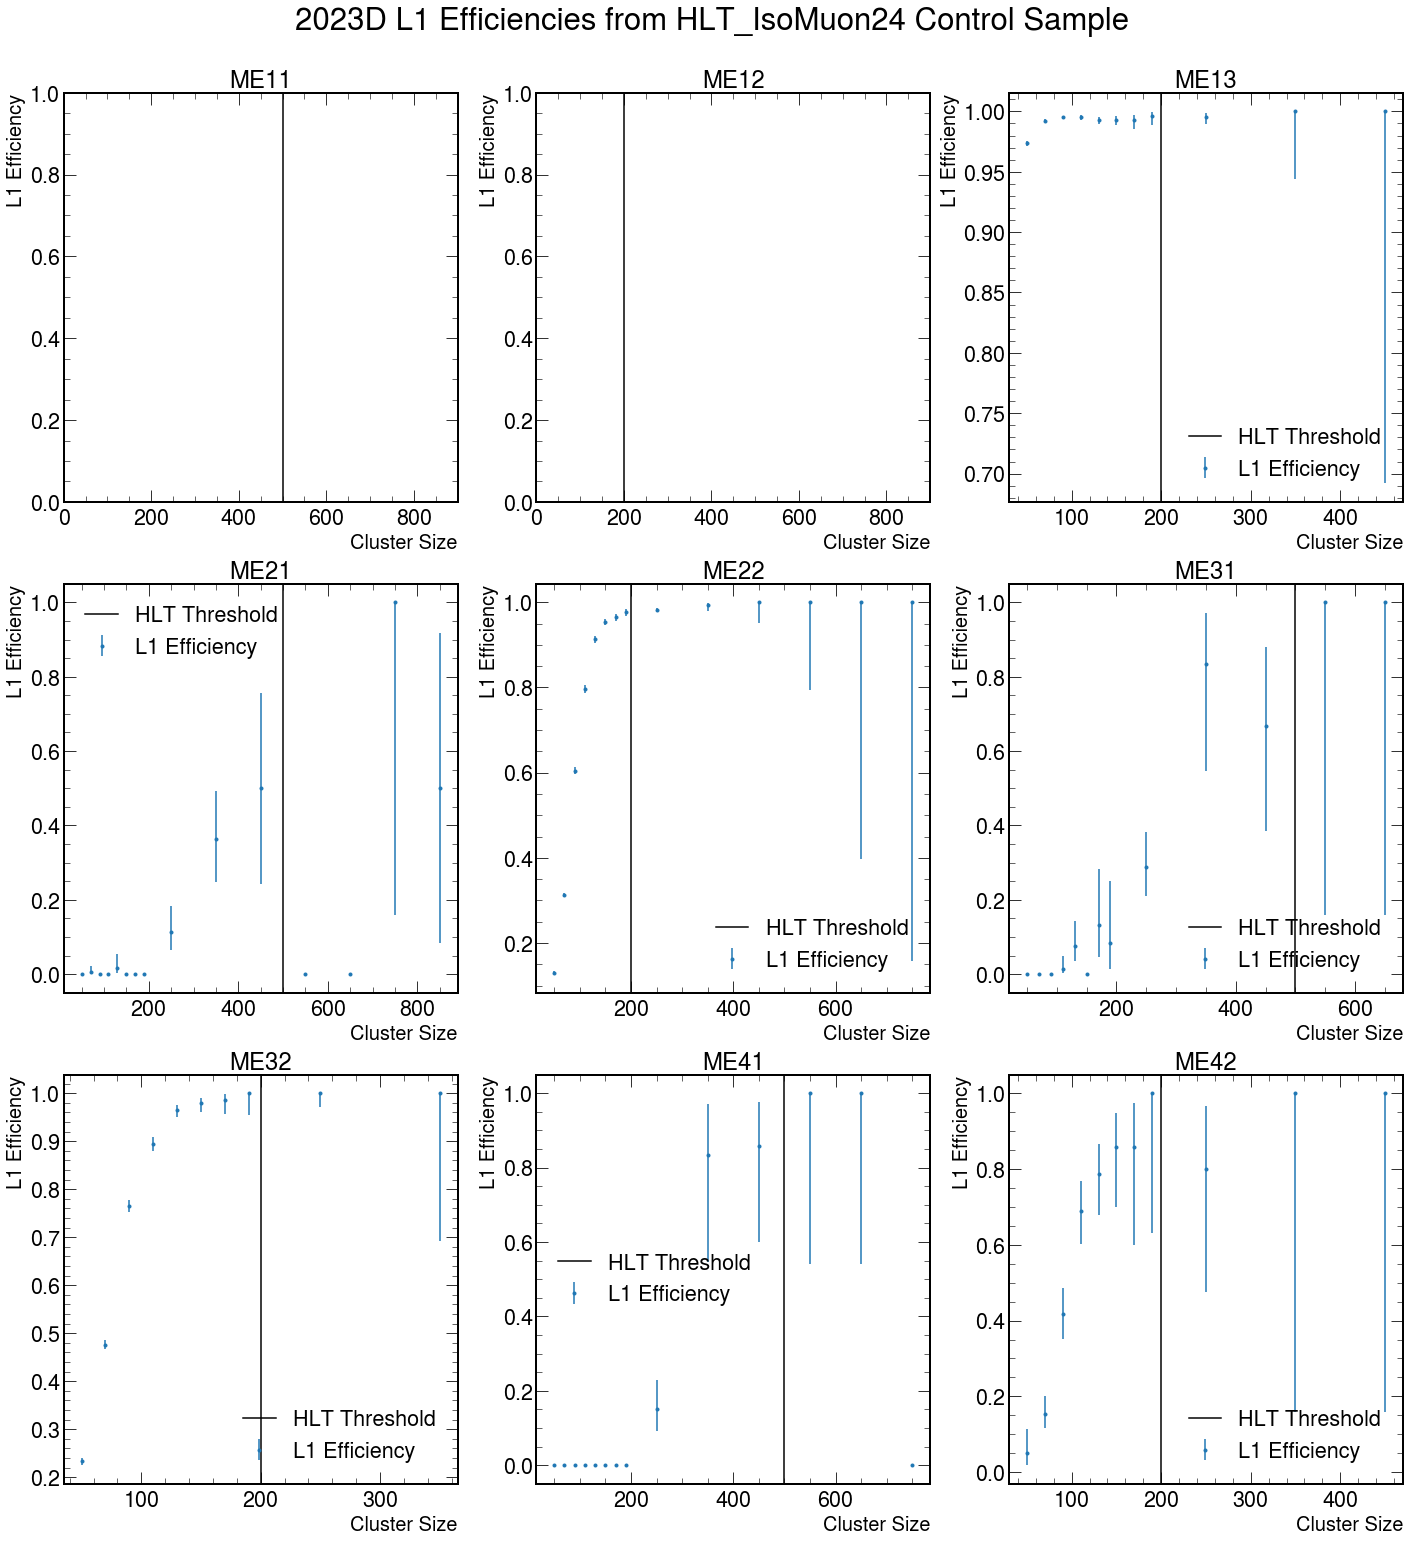

In [193]:
plt.style.use(hep.style.CMS) 
import matplotlib
num_rows = 3
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8 * num_cols, 8 * num_rows))
fig.suptitle(sample + " L1 Efficiencies from HLT_IsoMuon24 Control Sample")
#sample = "2023D"
bins = bins_rechits_lowEta_lowNStation10

counter = 0
for i in range(num_rows):
    for j in range(num_cols):
        chamber = list(chamber_locations.keys())[counter]
        maskZ = np.logical_and(abs(ak.flatten(oneClusterEvents[sample].cscRechitClusterZ))>chamber_locations[chamber]["minZ"], abs(ak.flatten(oneClusterEvents[sample].cscRechitClusterZ))<chamber_locations[chamber]["maxZ"])
        maskR = ak.flatten(np.logical_and((np.sqrt(oneClusterEvents[sample].cscRechitClusterX**2+oneClusterEvents[sample].cscRechitClusterY**2))>chamber_locations[chamber]["MinR"], (np.sqrt(oneClusterEvents[sample].cscRechitClusterX**2+oneClusterEvents[sample].cscRechitClusterY**2))<chamber_locations[chamber]["MaxR"]))
        total_mask = np.logical_and(np.logical_and(maskZ, maskR), ak.flatten(oneClusterEvents[sample]["cscRechitClusterNStation10"]==1))
        denom = ak.mask(ak.flatten(oneClusterEvents[sample].cscRechitClusterSize), total_mask)
        
        num = ak.mask(denom, ak.mask(oneClusterEvents[sample].L1_SingleMuShower_Nominal,total_mask))
        denom = denom[~ak.is_none(denom)]
        num = num[~ak.is_none(num)]
        counter+=1
        axes[i,j].set_title(chamber, fontsize=24)
        axes[i,j].axvline(chamber_locations[chamber]["HLT_thresh"], color="black", label="HLT Threshold")
        if ak.count(denom)==0: 
            axes[i][j].set_xlabel("Cluster Size", fontsize=20)
            axes[i,j].set_ylabel("L1 Efficiency", fontsize=20)
            axes[i,j].set_xlim(0,900)
            continue
        num_hist = hist.Hist("Counts", rechits_axis, bins)
        arr_to_fill = num
        num_hist.fill(sample = f"{ak.count(arr_to_fill)} entries", cluster_size=arr_to_fill)
        
        denom_hist = hist.Hist("Counts", rechits_axis, bins)
        arr_to_fill = denom
        denom_hist.fill(sample = f"{ak.count(arr_to_fill)} entries", cluster_size=arr_to_fill)
        
        hist.plotratio(
                    ax=axes[i,j],
                    num =num_hist.project(bins),
                    denom=denom_hist.project(bins),
                    error_opts={'marker': '.'},
                    unc='clopper-pearson',
                    label= "L1 Efficiency",
                    clear=False
                )
        '''
        hist.plotratio(
                    ax=axes[2],
                    num  =rechits_hist_HLTMedium.project(bins_rechits),
                    denom=rechits_hist.project(bins_rechits),
                    error_opts={'marker': '.'},
                    unc='clopper-pearson',
                    label= "Medium",
                    clear=False
                )

        hist.plotratio(
                    ax=axes[2],
                    num  =rechits_hist_HLTTight.project(bins_rechits),
                    denom=rechits_hist.project(bins_rechits),
                    error_opts={'marker': '.'},
                    unc='clopper-pearson',
                    label= "Tight",
                    clear=False
                )
        '''
        axes[i,j].legend()
        #axes[i,j].set_title(chamber, fontsize=24)
        axes[i][j].set_xlabel("Cluster Size", fontsize=20)
        axes[i,j].set_ylabel("L1 Efficiency", fontsize=20)
        
plt.subplots_adjust(top=0.93)
plt.savefig("L1_Efficiencies.png")
plt.show()
